# Programming for Data Analytics Project

*Author: Eoghan Walsh*

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import csv
import re
import requests
from io import StringIO

In [146]:
# Function to find start of data in file.
def skiprows(csv_file, regex_pattern):
    
    
    with open(csv_file) as f:
        reader = csv.reader(f)
        for row_number, row in enumerate(reader, start=0):
           if any(re.search(regex_pattern, string) for string in row):
              break
    return row_number

csv_file = "./data/cork_airport_weather_hourly.csv"

regex_pattern = "^date(?!:)"

cork_airport_df = pd.read_csv(csv_file, skiprows=skiprows(csv_file, regex_pattern), index_col="date", usecols=["date", "rain", "temp", "wdsp"], low_memory=False)

In [147]:
cork_airport_df.head()

,rain,temp,wdsp
date,,,
01-jan-1962 01:00,,-1.1,14
01-jan-1962 02:00,,-1.1,10
01-jan-1962 03:00,,-1.0,12
01-jan-1962 04:00,,-1.6,8
01-jan-1962 05:00,,-2.1,11


In [148]:
cork_airport_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551520 entries, 01-jan-1962 01:00 to 01-dec-2024 00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rain    551520 non-null  object 
 1   temp    551520 non-null  float64
 2   wdsp    551520 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 16.8+ MB


In [149]:
cork_airport_df.index = pd.to_datetime(cork_airport_df.index, format="%d-%b-%Y %H:%M")

In [150]:
cork_airport_df["rain"] = pd.to_numeric(cork_airport_df["rain"], errors="coerce")

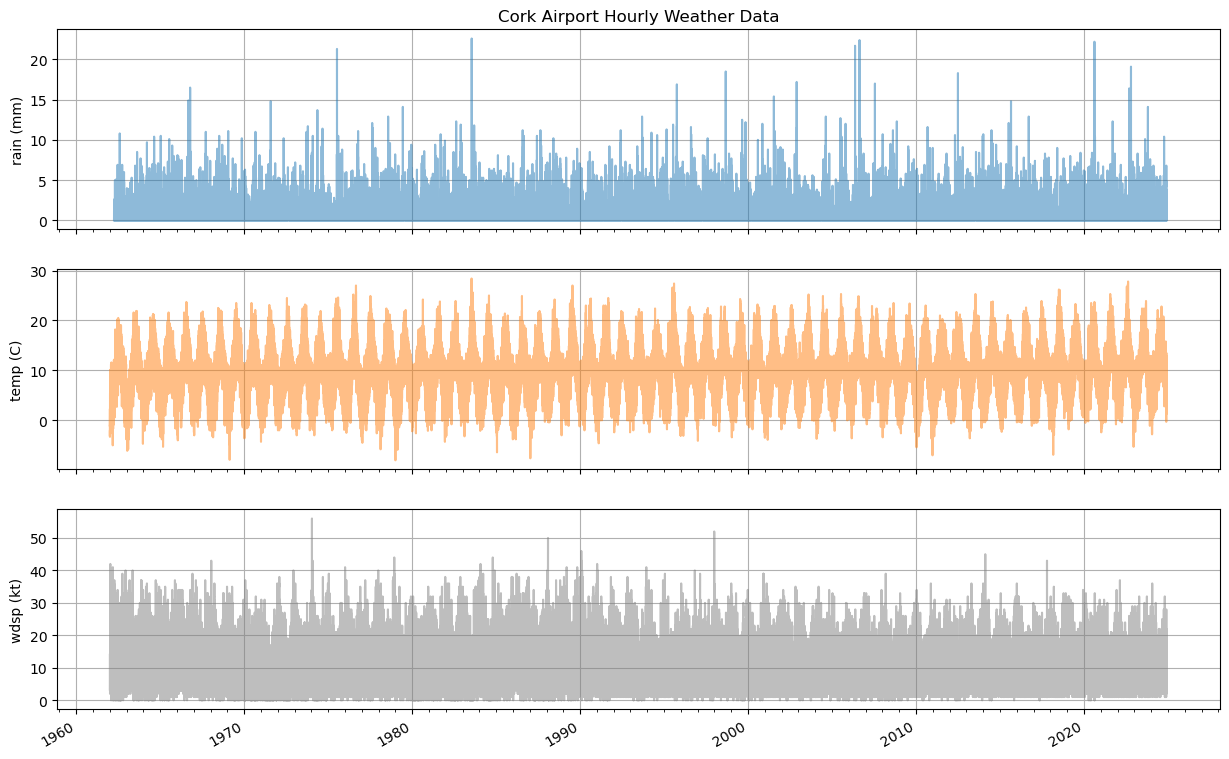

In [151]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 10))

ax1.plot(cork_airport_df["rain"], color="tab:blue", alpha=0.5)
ax2.plot(cork_airport_df["temp"], color="tab:orange", alpha=0.5)
ax3.plot(cork_airport_df["wdsp"], color="tab:gray",alpha=0.5)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_formatter(formatter)
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
fig.autofmt_xdate()

ax1.set_ylabel("rain (mm)")
ax2.set_ylabel("temp (C)")
ax3.set_ylabel("wdsp (kt)")

for ax in ax1, ax2, ax3:
    ax.grid(True)

ax1.set_title("Cork Airport Hourly Weather Data")

plt.show()

In [152]:
cork_airport_monthly = cork_airport_df.resample("ME").mean()

In [153]:
cork_airport_monthly["month"] = cork_airport_monthly.index.month

In [154]:
cork_airport_monthly

,rain,temp,wdsp,month
date,,,,
1962-01-31,NaN,5.440915,12.761777,1
1962-02-28,NaN,5.423810,13.642857,2
1962-03-31,NaN,4.074731,10.272849,3
1962-04-30,0.095278,7.534306,11.683333,4
1962-05-31,0.108468,9.467070,11.998656,5
...,...,...,...,...
2024-08-31,0.096237,14.742204,9.575269,8
2024-09-30,0.133611,12.995556,9.679167,9
2024-10-31,0.194355,11.300672,9.379032,10


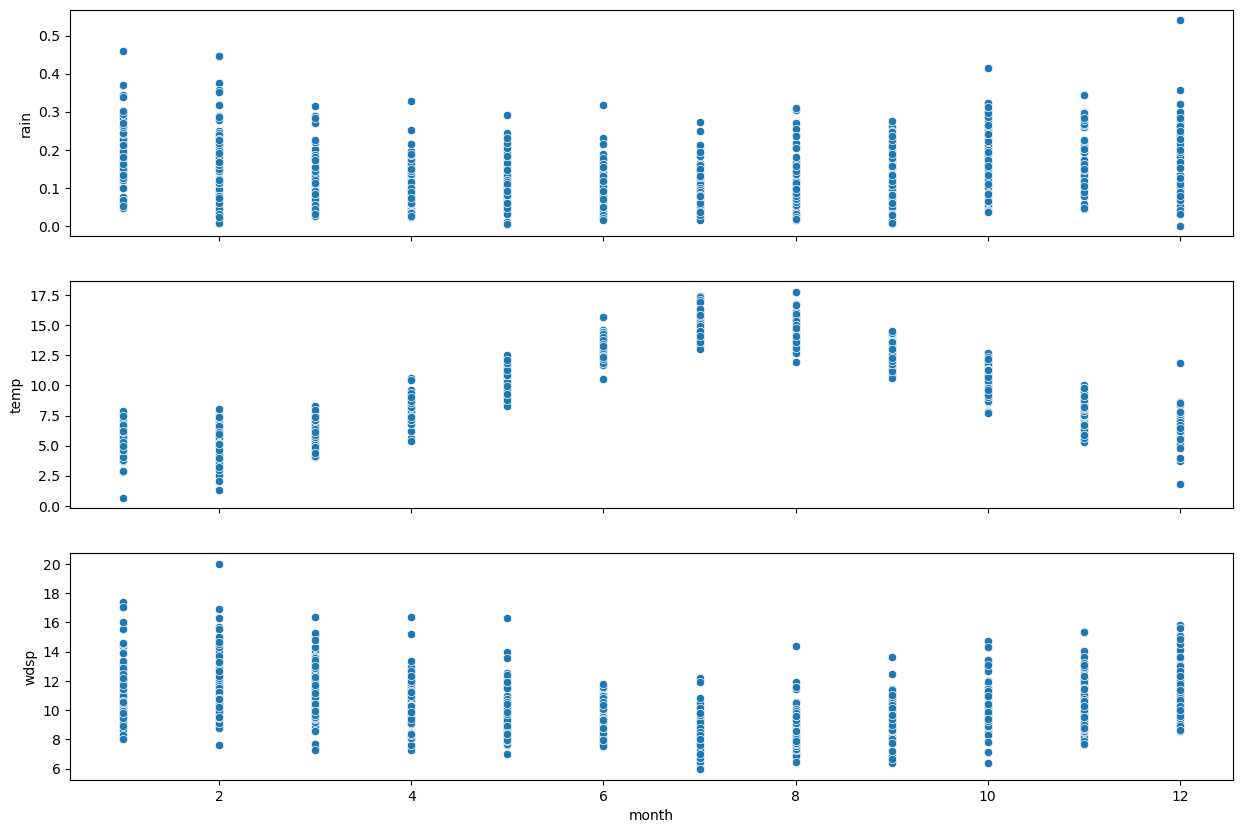

In [155]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 10))

#title = "Cork Airport Monthly Mean Temperature"
#xlabel = "month"
#ylabel = "temp (C)"
#line_kws = {"color": "tab:red"}
#scatter_kws = {"color": "tab:orange", "alpha": 0.5}

#sns.lmplot(data=cork_airport_monthly, x="month", y="temp", order=5, line_kws=line_kws, scatter_kws=scatter_kws).set(title=title, xlabel=xlabel, ylabel=ylabel)

sns.scatterplot(data=cork_airport_monthly, x="month", y="rain", ax=ax1)
sns.scatterplot(data=cork_airport_monthly, x="month", y="temp", ax=ax2)
sns.scatterplot(data=cork_airport_monthly, x="month", y="wdsp", ax=ax3)

plt.show()

In [156]:
december = cork_airport_monthly[cork_airport_monthly["month"] == 12]

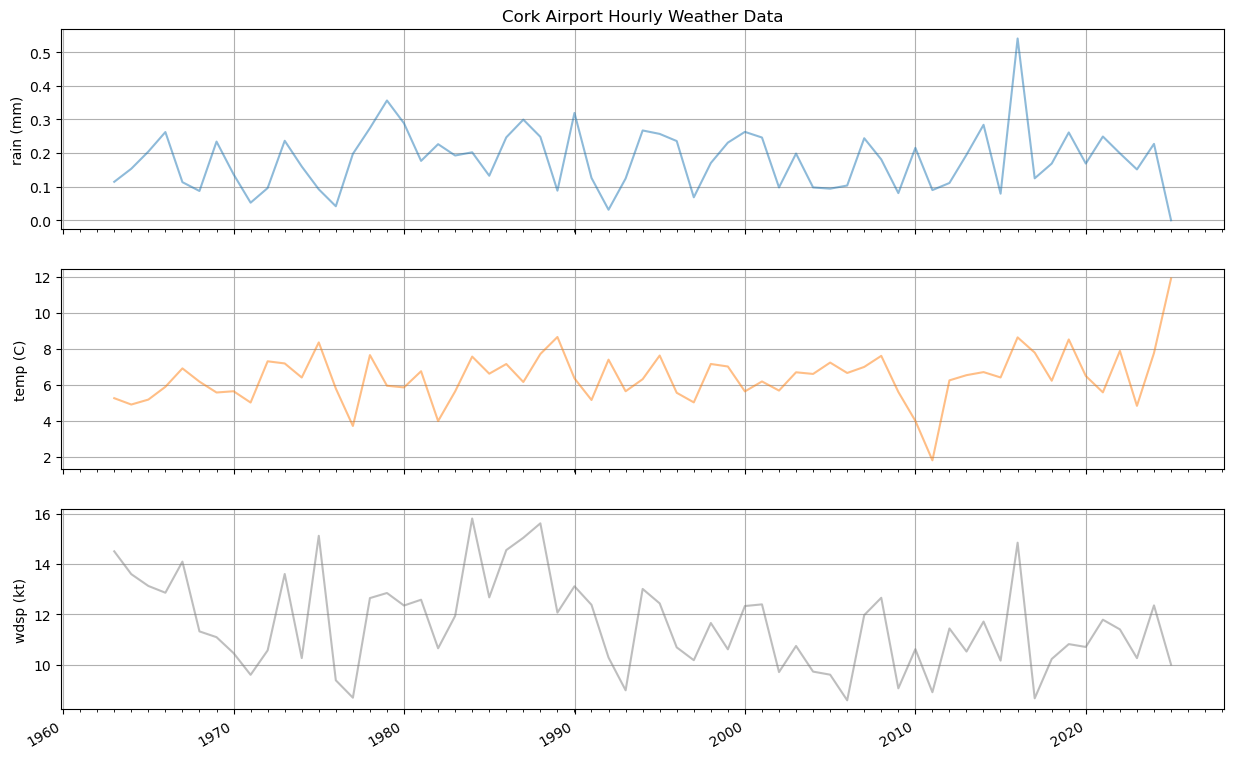

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 10))

ax1.plot(december["rain"], color="tab:blue", alpha=0.5)
ax2.plot(december["temp"], color="tab:orange", alpha=0.5)
ax3.plot(december["wdsp"], color="tab:gray",alpha=0.5)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_formatter(formatter)
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
fig.autofmt_xdate()

ax1.set_ylabel("rain (mm)")
ax2.set_ylabel("temp (C)")
ax3.set_ylabel("wdsp (kt)")

for ax in ax1, ax2, ax3:
    ax.grid(True)

ax1.set_title("Cork Airport Hourly Weather Data")

plt.show()

## Historical Daily Weather Data

In [ ]:
# Function to import daily weather data to dataframes.
def process_csv_urls(txt_file, regex, columns, index, date_format):
    """
    Import CSV files from Met Eireann URLs listed in a text file and return a dictionary of DataFrames.

    Parameters:
        txt_file (str): Path to the text file containing CSV URLs.
        pattern (str): Regex pattern.
        columns (list): List of columns to import to DataFrames.
        index (str): Column to set as the index for the DataFrames.

    Returns:
        dict: A dictionary of DataFrames.
    """
    # Dictionary to store the dataframes.
    dataframes = {}

    # Regex pattern to find the column header row in CSV files.
    regex_pattern = re.compile(regex, re.IGNORECASE)

    # Read the URLs from the txt file and strip newlines.
    with open(txt_file) as f:
        csv_urls = [line.strip() for line in f if line.strip()]

    # Loop through the URLs.
    for url in csv_urls:
        try:
            # Send GET request to the URL.
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")
                continue

            # Treat response content as file-like object.
            csv_content = response.text
            csv_file = StringIO(csv_content)

            # Find the row with colum headers.
            csv_reader = csv.reader(csv_file)
            for row_number, row in enumerate(csv_reader):
                row_string = ",".join(row)
                if regex_pattern.search(row_string):
                    #print(f"Skipped {row_number} rows in {url}")
                    break
            else:
                print(f"Error finding regex pattern: \"{regex_pattern.pattern}\" in {url}")
                continue

            # Reset the file pointer get weather station name.
            csv_file.seek(0)
            for row in csv_reader:
                row_string = ",".join(row)
                df_name = row_string.split("Station Name: ")[1].lower()
                break
            else:
                print(f"Could not extract Station Name from {url}")
                df_name = url.split("webdata/")[1].rstrip(".csv")
                continue
            
            # Reset the file pointer and import the data to DataFrame.
            csv_file.seek(0)
            dataframes[df_name] = pd.read_csv(csv_file, skiprows=row_number, index_col=index, usecols=columns)
            
            # Convert index to datetime.
            dataframes[df_name].index = pd.to_datetime(dataframes[df_name].index, format=date_format)

            # Convert data to numeric.
            dataframes[df_name]["wdsp"] = pd.to_numeric(dataframes[df_name]["wdsp"], errors="coerce")
            print(f"Imported {url} as {df_name}")

        except Exception as e:
            print(f"An error occurred while processing {url} ({df_name}): {e}")

    return dataframes


# File containing csv URLs.
txt_file = "./data/download-file-list-daily.txt"

# Regex pattern to find the start of useful data in CSV files.
regex = r"^date(?!:)"

# Columns to import to dataframe.
columns = ["date", "wdsp"]

# Set index in dataframe.
index = "date"

# Convert index to datetime.
date_format = "%d-%b-%Y"

# Call the function.
dataframes = process_csv_urls(txt_file, regex, columns, index, date_format)

Imported https://cli.fusio.net/cli/climate_data/webdata/dly1875.csv as athenry
Imported https://cli.fusio.net/cli/climate_data/webdata/dly675.csv as ballyhaise
Imported https://cli.fusio.net/cli/climate_data/webdata/dly2375.csv as belmullet
Imported https://cli.fusio.net/cli/climate_data/webdata/dly3723.csv as casement
Imported https://cli.fusio.net/cli/climate_data/webdata/dly2175.csv as claremorris
Imported https://cli.fusio.net/cli/climate_data/webdata/dly3904.csv as cork airport
Imported https://cli.fusio.net/cli/climate_data/webdata/dly532.csv as dublin airport
Imported https://cli.fusio.net/cli/climate_data/webdata/dly1375.csv as dunsany
Imported https://cli.fusio.net/cli/climate_data/webdata/dly2075.csv as finner
Imported https://cli.fusio.net/cli/climate_data/webdata/dly1475.csv as gurteen
Imported https://cli.fusio.net/cli/climate_data/webdata/dly1775.csv as johnstown castle 2
Imported https://cli.fusio.net/cli/climate_data/webdata/dly4935.csv as knock airport
Imported https:/

In [161]:
# Merge the dataframes based on the index.
merged_df = pd.concat(dataframes, axis=1, join="outer")

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30316 entries, 1942-01-01 to 2024-12-31
Freq: D
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   (athenry, wdsp)               5421 non-null   float64
 1   (ballyhaise, wdsp)            7722 non-null   float64
 2   (belmullet, wdsp)             24943 non-null  float64
 3   (casement, wdsp)              21173 non-null  float64
 4   (claremorris, wdsp)           27207 non-null  float64
 5   (cork airport, wdsp)          23009 non-null  float64
 6   (dublin airport, wdsp)        30316 non-null  float64
 7   (dunsany, wdsp)               6808 non-null   float64
 8   (finner, wdsp)                5088 non-null   float64
 9   (gurteen, wdsp)               6169 non-null   float64
 10  (johnstown castle 2, wdsp)    5913 non-null   float64
 11  (knock airport, wdsp)         10369 non-null  float64
 12  (mace head, wdsp)             7750 

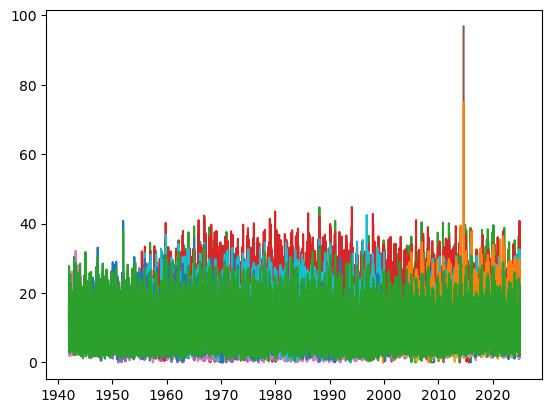

In [163]:
fig, ax = plt.subplots()

ax.plot(merged_df)

plt.show()

# 